# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and
Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python),
and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/).
    Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml)
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors.
The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model),
which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic.
By default, each outcome array will then have a shape of (# experiments, # replications, # time steps).
Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

c:\users\marko\appdata\local\programs\python\python38\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
c:\users\marko\appdata\local\programs\python\python38\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "
c:\users\marko\appdata\local\programs\python\python38\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


Maximum absolute error Excel: 8.6922


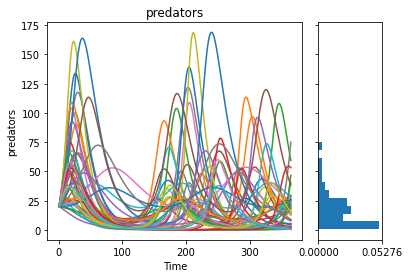

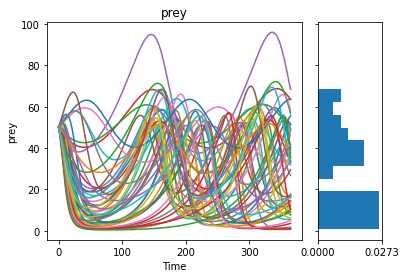

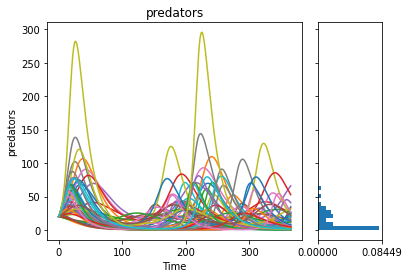

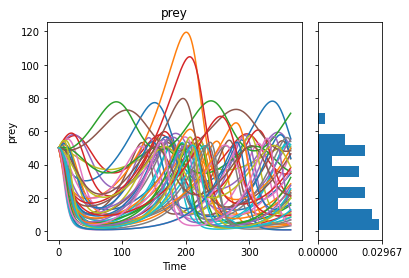

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, SequentialEvaluator)
from ema_workbench.analysis import plotting, plotting_util
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density

def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time, 'predators':predators, 'prey':prey}

    #return sim_time, predators, prey

# Instantiate Python model
modelPython = Model('PredPreyPython', function=PredPrey) # instantiate the model

# Instantiate Python model
modelExcel = ExcelModel("PredPrey", wd="./model", model_file='PredPrey.xlsx')
modelExcel.default_sheet = "Sheet1"

# Function expects an instance of a model and plots it
def plot_lotka_volterra(model_instance):

    model_instance.uncertainties = [RealParameter ('prey_birth_rate', 0.015, 0.035),
                                 RealParameter ('predation_rate', 0.0005, 0.003),
                                 RealParameter ('predator_efficiency', 0.001, 0.004),
                                 RealParameter ('predator_loss_rate', 0.04, 0.08)
                                 ]

    model_instance.outcomes = [TimeSeriesOutcome('TIME'),
                            TimeSeriesOutcome('predators'),
                            TimeSeriesOutcome('prey')]

    with SequentialEvaluator(model_instance) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(scenarios=50)

        outcomes_squeezed = {}

        for key in outcomes:
            outcomes_squeezed[key] = np.squeeze(outcomes[key])

        # Thoughts for the error calculation:
        # For every key (predators, prey), at every time step, calculate the average over all scenarios
        # Then, we have a list of averages for all time steps
        # Then, calculate the difference between the list from Excel and the list from Python.
        # Then, find the maximum deviation. This is our maximum absolute error.

        outcomes_average = {}

        for outcome_key in outcomes_squeezed.keys():
            if outcome_key != 'TIME':
                # Fetch numpy array from dictionary, and calculate average over every single column (average at every point of time)
                outcomes_average[key] = np.mean(outcomes_squeezed[key], axis=0)

                # Plot using workbench
                plotting.lines(experiments, outcomes_squeezed, outcomes_to_show=outcome_key, density=plotting_util.Density.HIST)

    return outcomes_average

# Run plot for the models
outcomes_average_python = plot_lotka_volterra(modelPython)
outcomes_average_excel = plot_lotka_volterra(modelExcel)

# Error calculation
outcomes_average_difference_prey = outcomes_average_excel['prey'] - outcomes_average_python['prey']
max_error = np.amax(outcomes_average_difference_prey)

print("Maximum absolute error Excel: {:.4f}".format(max_error))
plt.show()